## Stock market prediction based on patent novelty


In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/all_novelty.csv")
stock_prices = pd.read_csv("data/stockprices_2000_2020.csv")
print(df.shape)
print(stock_prices.shape)

(427, 15)
(369810, 3)


In [3]:
df.ticker.value_counts()

CL     335
CHD     70
HSY     18
CPB      4
Name: ticker, dtype: int64

In [4]:
stock_prices = stock_prices[(stock_prices["Ticker"]=="CL") | 
                            (stock_prices["Ticker"]=="CHD") |
                            (stock_prices["Ticker"]=="HSY") |
                            (stock_prices["Ticker"]=="CPB")]
stock_prices.shape

(21132, 3)

In [11]:
# Keeping range of dates for which we have patent data

stock_prices["date"] = pd.to_datetime(stock_prices["Date"])
df["date"] = pd.to_datetime(df["issue_date"])
stock_prices = stock_prices[(stock_prices["date"]>=df.date.min()) &
                            (stock_prices["date"]<=df.date.max())]
stock_prices = stock_prices.drop(columns=["Date"])

stock_prices = stock_prices.rename(columns={'Ticker': 'ticker'})

In [13]:
stock_prices.head()

,ticker,Adj Close,date
145157,CHD,-0.013531,2010-01-05
145158,CHD,0.004792,2010-01-06
145159,CHD,-0.011184,2010-01-07
145160,CHD,-0.002162,2010-01-08
145161,CHD,-0.004334,2010-01-11


In [14]:
# Many patents are published on the same date - we average the novelty measures

df_reduc = df.drop(columns=["text", "patent_id", "clean_corpus", "issue_date"])
df2_avg = df_reduc.groupby(['ticker', 'date', 'sector']).mean().reset_index()
df2_avg.shape

(256, 12)

In [16]:
# Merging the two datasets
merged = pd.merge(stock_prices, df2_avg, on=["date", "ticker"], how="left")
merged.shape

(8928, 13)

We end up with a dataset with a lot of NA values, since we have data for 8928 days/tickers, but new patents were only released in 256 cases.

In [17]:
merged.to_csv("data/stockprices_novelty_merged.csv")

## Preprocessing and modelling

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error

In [19]:
df = pd.read_csv("data/stockprices_novelty_merged.csv").drop(columns=["Unnamed: 0"])

# Sector does not give us extra information

df = df.drop(columns=["sector"])

# Calculate the maximum value within each group
numpatents = df.groupby('ticker')['numpat_total'].transform('max')

# Assign the maximum values to a new column 'max_value'
df['numpat_total'] = numpatents

test_time_start = '2017'

df = df.fillna(0) # Filling NAs with 0 (signaling "no innovation")

df["date"] = pd.to_datetime(df["date"])

df.sort_values(['ticker', 'date'], inplace=True)


### Benchmark

+ Naive model

We started by buiding a naive prediction model that forecasts the future values of the target variable using the last known value for each observation. This approach assumes that the future values of the target variable will be similar to the previous observed values, making it a simple baseline model for comparison with more sophisticated prediction techniques.

In [20]:
test_time_start = '2017-01-01'
train = df.loc[df.date < test_time_start]
test = df.loc[df.date >= test_time_start]

companies = df['ticker'].unique()

def apply_naive_prediction(train, test, target, companies):
    y_pred = []  # Initialize y_pred as an empty list
    for c in companies:
        train_c = train[train["ticker"]==c]
        test_c = test[test["ticker"]==c]

        y_pred_1 = train_c[target].iloc[-1]
        y_pred_2 = test_c[target].shift(1)  # Shift the values by 1 timestep
        y_pred_c = y_pred_2.fillna(y_pred_1)
        y_pred.append(y_pred_c)  # Append the predicted values to y_pred list

    return pd.concat(y_pred)  # Concatenate the predicted values into a single series or dataframe


y_pred = apply_naive_prediction(train, test, "Adj Close", companies)

mse = mean_squared_error(test["Adj Close"], y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.00033931651339462644


### Model 1
+ Effect of new patent on the following day (Same as Benchmark).
+ Missing values imputed as 0 (signaling "no innovation"). 
+ Fixed effects by company (ticker dummies).
+ Include past information for stock market variation (lags for 3, 6, 15, 30, 60, 120 days)
+ Model: RF + hyperparameter tunning

In [21]:
# Shifting target by 1 day

# Function for defining Y variable

def make_target(df, t):
    '''t is the number of periods to shift forward'''
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(by=['ticker', 'date'])

    # loop through each period and generate the shift variables
    for i in range(1, t+1):
        col_name = f'Adj Close{i}'
        df[col_name] = df.groupby(['ticker'])['Adj Close'].shift(-i)

    # take the maximum for t periods forward and create the new variable
    df['target_f{}'.format(t)] = df[[f'Adj Close{i}' for i in range(1, t+1)]].max(axis=1, skipna=False)

    # drop the shift variables
    df = df.drop(columns=[f'Adj Close{i}' for i in range(1, t+1)])

    return(df)

In [22]:
df_target = make_target(df, 1)
df_target.tail()

,ticker,Adj Close,date,numpat_total,avg_similarity_5,avg_similarity_10,avg_similarity_20,nw,nb,nt,nwc,nov,target_f1
8923,HSY,0.003343,2018-11-07,27.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-0.009070
8924,HSY,-0.009070,2018-11-08,27.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.014103
8925,HSY,0.014103,2018-11-09,27.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000829
8926,HSY,0.000829,2018-11-12,27.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.004325
8927,HSY,0.004325,2018-11-13,27.0,0.235248,0.138532,0.097133,0.0,0.0,0.0,0.0,0.0,NaN


In [23]:
# Here we generate variables for the past 3 to 120 days with a rolling mean of Adj Close
df_target["date"] = pd.to_datetime(df_target["date"])
panel_data= df_target.copy()
panel_data = panel_data.sort_values(by=['ticker', 'date'])
lcols = (panel_data.groupby(['ticker'])['Adj Close'] 
         .transform(lambda x: x.rolling(w, min_periods=1).sum()) # rolling sum of number of reports
         .rename('past' + str(w-1)) 
         for w in [4, 7, 16, 31, 61, 121])
panel_data = panel_data.join(pd.DataFrame(lcols).transpose())

In [24]:
# OHE for ticker

dummies = pd.get_dummies(panel_data['ticker'], dtype=int)
merged = pd.concat([panel_data, dummies], axis=1)

merged = merged.drop(columns=["ticker", "Adj Close"])


In [25]:
# Split the data into training and test 
train = merged.loc[merged.date < test_time_start]
test = merged.loc[merged.date >= test_time_start]
test = test.dropna()

X_train = train.drop('target_f1', axis=1).drop(columns=["date"])  # Features
y_train = train['target_f1']  # Target variable
X_test = test.drop('target_f1', axis=1).drop(columns=["date"])  # Features
y_test = test['target_f1']  # Target variable

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training features
scaler.fit(X_train)

# Apply the scaler to both the training and test features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 5, 7, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00017210385348447716


Comparing this MSE to the Benchmark MSE we can say that this model outperforms the Benchmark model, proving that incorporating additional features such as fixed effects, imputating missing values, adding lagged variables, and tunning the hyperparamenters of the Random Forest model did indeed get closer predictions to the actual values.

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

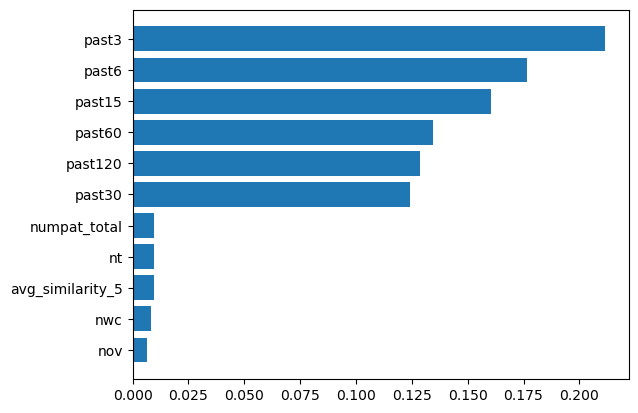

[8, 7, 1, 6, 0, 12, 14, 13, 11, 10, 9]

In [28]:
feature_names = X_train.columns

feature_imp(abs(best_model.feature_importances_), feature_names)

From this plot we can interpret that the features with the highest importance are the variables related to the past 3, past 6, and past 15, past 60, past 120 and past 30. These are the variables that are more significant to the model's prediction power.

### Model 2

+ Effect of new patent on the following day (Same as Benchmark). 
+ Missing values imputed as 0 (signaling "no innovation"). 
+ Instead of fixed effects by company (ticker dummies), one model per company.
+ Include past information for stock market variation (lags for 3, 6, 15, 30, 60, 120 days)
+ Model: RF + hyperparameter tunning

Instead of using fixed effects to capture company-specific characteristics, this Model 2 trains a separate model for each individual company. This means that a distinct Random Forest model is built for each company on the chosen sector.

In [29]:
df_copy = panel_data.copy()


# Drop unnecesary columns
df_copy = df_copy.drop(columns=["Adj Close"])

In [30]:
df_copy = panel_data.copy()


# Drop unnecesary columns
df_copy = df_copy.drop(columns=["Adj Close"])

# Get the unique company names from the DataFrame
companies = df_copy['ticker'].unique()

# Create an empty dictionary to store the trained models and MSE values
results = {}

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 5, 7, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

# Iterate over the companies
for company in companies:
    # Subset the data for the current company
    company_data = df_copy[df_copy['ticker'] == company]
    company_data = company_data.dropna()
    company_data = company_data.drop(columns=["ticker"])
   # Split the data into training and test 
    train = company_data.loc[company_data.date < test_time_start]
    test = company_data.loc[company_data.date >= test_time_start]

    X_train = train.drop('target_f1', axis=1).drop(columns=["date"])  # Features
    y_train = train['target_f1']  # Target variable
    X_test = test.drop('target_f1', axis=1).drop(columns=["date"])  # Features
    y_test = test['target_f1']  # Target variable

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler on the training features
    scaler.fit(X_train)

    # Apply the scaler to both the training and test features
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

  
    # Perform grid search for hyperparameter tuning
    rf_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    
    # Make predictions using the selected model
    y_pred = best_model.predict(X_test_scaled)
    
    # Calculate the mean squared error for the predictions
    mse = mean_squared_error(y_test, y_pred)
    
    # Store the best model and MSE in the dictionary
    results[company] = {
        'model': best_model,
        'mse': mse
    }



In [31]:
results

{'CHD': {'model': RandomForestRegressor(max_depth=5, min_samples_split=20, n_estimators=300,
                        random_state=42),
  'mse': 0.00015222288621109453},
 'CL': {'model': RandomForestRegressor(max_depth=5, min_samples_split=5, n_estimators=200,
                        random_state=42),
  'mse': 0.00013764454825737616},
 'CPB': {'model': RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42),
  'mse': 0.0002777173278876941},
 'HSY': {'model': RandomForestRegressor(max_depth=5, min_samples_split=20, n_estimators=50,
                        random_state=42),
  'mse': 0.0001273804779564348}}

It is evident that the MSE values obtained for each company using the separate Random Forest models are lower compared to the benchmark MSE, suggesting that the models built for each company are performing better in terms of prediction accuracy. 

The models for companies CHD, CL, and HSY also achieved lower MSE values when compared to the first model, indicating better predictive performance, while the model for company CPB resulted in a higher MSE value compared to that model.

### Model 3

+ ARIMA

AS a third model we incorporated an ARIMA model, since it is a popular time series forecasting model that incorporates autoregressive, moving average, and differencing components.

In [73]:
# !pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA

In [75]:
df_timeseries = df.copy()

df_timeseries["date"] = pd.to_datetime(df_timeseries["date"])

# Set the 'date' column as the index
df_timeseries.set_index('date', inplace=True)

In [76]:
import warnings
warnings.filterwarnings("ignore")

# Specify the order of the ARIMA model (p, d, q)
p = 1  # AR order
d = 1  # Differencing order
q = 1  # MA order

for company in companies:
    # Subset the data for the current company
    df_company = df_timeseries[df_timeseries['ticker'] == company].copy()
    # Resample time series because it only includes business days
    df_company = df_company.resample('B').interpolate()
    # Separate the target variable (stock values) and covariates
    y = df_company['Adj Close']
    X = df_company.drop(columns=["Adj Close", "ticker"])

    # Split the data into train and test based on date
    test_start_date = pd.to_datetime('2017-01-01')
    X_train = X[X.index < test_start_date]
    X_test = X[X.index >= test_start_date]
    y_train = y[y.index < test_start_date]
    y_test = y[y.index >= test_start_date]

    # Standardize the covariates using a scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled arrays back to a DataFrame with original column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    # Fit the ARIMA model with exogenous variables
    model = ARIMA(y_train, order=(p, d, q), exog=X_train_scaled)
    model_fit = model.fit()

    print("--------------------------")
    print(f"Company: {company}")
    print(model_fit.summary())
    # Make predictions on the test set with exogenous variables
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

    # Calculate the mean squared error (MSE) on the test set
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")



--------------------------
Company: CHD
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1824
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5577.869
Date:                Thu, 08 Jun 2023   AIC                         -11131.737
Time:                        17:15:54   BIC                         -11065.638
Sample:                    01-05-2010   HQIC                        -11107.353
                         - 12-30-2016                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
numpat_total               0         -0        nan        nan           0           0
avg_similarity_5     -0.0020      0.001     -1.753      0.080      -0.

Among the considered companies, the ARIMA model for HSY performed the best with the lowest MSE value, of 0.00011536545674962604, while the model for CPB had the highest MSE value, of 0.18745645096635652, indicating relatively poor performance. Knowing this we can also state that ARIMA models performed better than the benchmark model, except for the company CPB. 

When compared to the first Random Forest model in which we included a dummy variable for each company, these models also showed mixed performance. Once again the models for all companies except the CPB have a lower MSE that the one obtained in the first model (MSE = 0.00017210385348447716).

We can also add that when comparing these models with the second model that utilized separate Random Forest models with tuned hyperparameters for each company, it can be observed that the performance was generally comparable, with slight variations in mean squared error (MSE). For companies CHD and CL, both models demonstrated similar predictive accuracy. However, for company CPB, the ARIMA model had a notably higher MSE, indicating relatively poorer performance compared to the second model. And for company HSY, the ARIMA model showed a slightly lower MSE, therefore indicating better performance. 

As a final comment we wanted to mention thar overall we did see that it was harder for the models to predict correctly the values for the company CPB. This could be due to various factors such as the nature of the data, specific characteristics of the company, for example counting with very little patents within the observations, or limitations in the model's ability to capture the underlying patterns accurately. To investigate a little more on this we decided to do the following plot, to exhibits the variance on the stock value of each of the companies. 

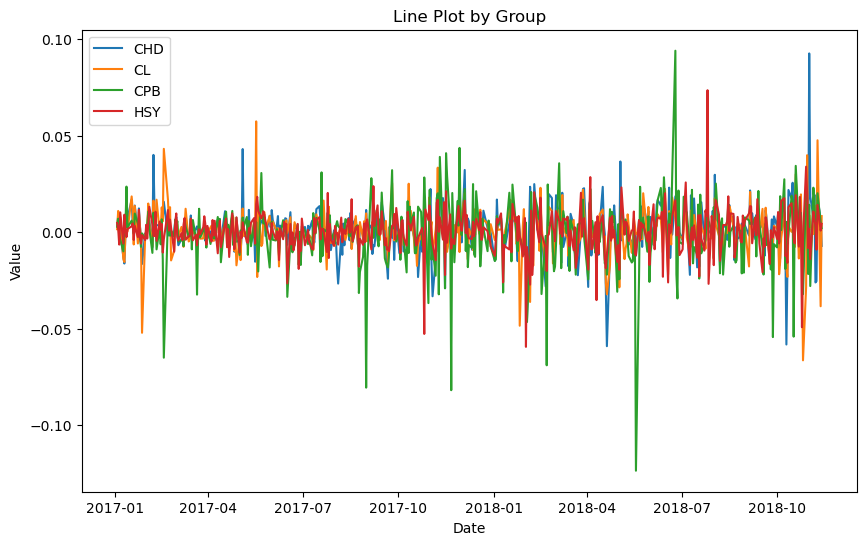

In [32]:
plt.figure(figsize=(10, 6))

test = df[df["date"]>="2017-01-01"]
sns.lineplot(data=test, x='date', y='Adj Close', hue="ticker")

plt.title('Line Plot by Group')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

A higher variance in stock value may indicate a more volatile market or company, which can introduce additional complexities in modeling and prediction. This can make it more challenging to predict the exact future values. But it does not necessarily imply that the company's predictionsare performing worse because of this exact reason. The performance of the predictions depends on various factors, including the modeling approach, data quality, feature selection, and the specific behavior of the company.